In [1]:
# Import libraries
import pandas as pd 
import seaborn as sns
import numpy as np
from keplergl import KeplerGl
from h3 import h3
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
#Import csv files & define inputs
demand_file = 'all_demand_hour_day_week.csv'
stations_file = 'chihuahua_stops_geocoord.csv'
city = 'Chihuahua'
h3_size = 9
demand_raw = pd.read_csv(demand_file)
stations_raw = pd.read_csv(stations_file)

In [4]:
# Verify data
demand_raw

,name_en,city_id,current_stat_hour,lat,lng,day_of_week,eyeballs,calls
0,Toluca,52151600,16.0,19.2970,-99.7696,weekday,1,1
1,Toluca,52151600,7.0,19.2782,-99.6488,weekday,4,4
2,Toluca,52151600,7.0,19.1901,-99.5628,weekday,4,3
3,Toluca,52151600,0.0,19.2914,-99.5854,weekday,1,1
4,Toluca,52151600,20.0,19.2700,-99.6406,weekday,4,2
...,...,...,...,...,...,...,...,...
976844,Chihuahua,52080200,9.0,28.7165,-106.0945,weekday,1,0
976845,Chihuahua,52080200,11.0,28.6001,-106.0357,weekend,1,1
976846,Oaxaca,52200100,20.0,17.0822,-96.7187,weekday,1,1
976847,Chihuahua,52080200,22.0,28.7338,-106.1308,weekend,1,0


In [24]:
print(f"the weekday demand (eyeballs) is: {demand_raw[(demand_raw.day_of_week== 'weekday') & (demand_raw.city_id == 52080200)].eyeballs.sum()}")
print(f"the weekend demand (eyeballs) is: {demand_raw[(demand_raw.day_of_week== 'weekend') & (demand_raw.city_id == 52080200)].eyeballs.sum()}")
print(f"the total demand (eyeballs) is: {demand_raw[demand_raw.city_id  == 52080200].eyeballs.sum()}")

print(f"the weekday demand (calls) is: {demand_raw[(demand_raw.day_of_week== 'weekday') & (demand_raw.city_id == 52080200)].calls.sum()}")
print(f"the weekend demand (calls) is: {demand_raw[(demand_raw.day_of_week== 'weekend') & (demand_raw.city_id == 52080200)].calls.sum()}")
print(f"the total demand (calls) is: {demand_raw[demand_raw.city_id  == 52080200].calls.sum()}")

the weekday demand (eyeballs) is: 363692
the weekend demand (eyeballs) is: 142220
the total demand (eyeballs) is: 505912
the weekday demand (calls) is: 220996
the weekend demand (calls) is: 73917
the total demand (calls) is: 294913


In [5]:
#verify data
stations_raw.head()

,name,para_id,lat,lng
0,R1,1,28.750434,-106.129590
1,R1,2,28.747102,-106.127692
2,R1,3,28.742250,-106.125337
3,R1,4,28.735351,-106.122737
4,R1,5,28.727643,-106.120540


In [6]:
# Create new df
demand = demand_raw.copy()
stations = stations_raw.copy()

In [7]:
demand[["name_en", 'city_id', 'day_of_week']] = demand[["name_en", 'city_id', 'day_of_week']].astype(str)
demand = demand[demand.name_en == city]

In [8]:
# check data stats
demand.info()
demand.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 384425 entries, 43 to 976848
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name_en            384425 non-null  object 
 1   city_id            384425 non-null  object 
 2   current_stat_hour  384424 non-null  float64
 3   lat                384425 non-null  float64
 4   lng                384425 non-null  float64
 5   day_of_week        384425 non-null  object 
 6   eyeballs           384425 non-null  int64  
 7   calls              384425 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 26.4+ MB


,name_en,city_id,current_stat_hour,lat,lng,day_of_week,eyeballs,calls
count,384425,384425,384424.000000,384425.000000,384425.000000,384425,384425.000000,384425.000000
unique,1,1,NaN,NaN,NaN,2,NaN,NaN
top,Chihuahua,52080200,NaN,NaN,NaN,weekday,NaN,NaN
freq,384425,384425,NaN,NaN,NaN,267109,NaN,NaN
mean,NaN,NaN,13.816047,28.662320,-106.080345,NaN,1.316023,0.767154
std,NaN,NaN,6.050844,0.067961,0.051420,NaN,0.940464,0.831640
min,NaN,NaN,0.000000,0.000000,-106.558400,NaN,1.000000,0.000000
25%,NaN,NaN,10.000000,28.621400,-106.118700,NaN,1.000000,0.000000
50%,NaN,NaN,15.000000,28.656300,-106.091700,NaN,1.000000,1.000000
75%,NaN,NaN,19.000000,28.696400,-106.045900,NaN,1.000000,1.000000


In [9]:
# add h3 to df
demand['h3']=[h3.geo_to_h3(x,y,h3_size) for (x,y) in zip(demand.lat,demand.lng)]
stations['h3']=[h3.geo_to_h3(x,y,h3_size) for (x,y) in zip(stations.lat,stations.lng)]

In [10]:
stations

,name,para_id,lat,lng,h3
0,R1,1,28.750434,-106.129590,8948f4b241bffff
1,R1,2,28.747102,-106.127692,8948f4b24cfffff
2,R1,3,28.742250,-106.125337,8948f4b24dbffff
3,R1,4,28.735351,-106.122737,89481b499b3ffff
4,R1,5,28.727643,-106.120540,89481b48a5bffff
5,R1,6,28.728260,-106.113420,89481b4999bffff
6,R1,7,28.724448,-106.111750,89481b49d67ffff
7,R1,8,28.704772,-106.125082,89481b48e5bffff
8,R2,1,28.729317,-106.148266,89481b48aa7ffff
9,R2,2,28.721741,-106.148462,89481b4884bffff


In [11]:
demand_agg = (demand
          .groupby(['day_of_week', 'current_stat_hour', 'h3'])
          .agg(eyeballs= ('eyeballs', 'sum'), 
              calls = ('calls', 'sum')
              )
          .reset_index()
         )
demand_agg

,day_of_week,current_stat_hour,h3,eyeballs,calls
0,weekday,0.0,89481b48007ffff,9,3
1,weekday,0.0,89481b4800bffff,4,0
2,weekday,0.0,89481b4800fffff,2,2
3,weekday,0.0,89481b48013ffff,7,3
4,weekday,0.0,89481b48017ffff,1,1
...,...,...,...,...,...
67798,weekend,23.0,8948f4ba29bffff,5,2
67799,weekend,23.0,8948f4ba64bffff,2,0
67800,weekend,23.0,8948f4ba64fffff,1,0
67801,weekend,23.0,8948f4bb58bffff,2,0


In [12]:
# left join df
stations_join = stations.merge(demand_agg, how = 'left', on = 'h3')
stations_join

,name,para_id,lat,lng,h3,day_of_week,current_stat_hour,eyeballs,calls
0,R1,1,28.750434,-106.129590,8948f4b241bffff,weekday,0.0,25,17
1,R1,1,28.750434,-106.129590,8948f4b241bffff,weekday,1.0,4,2
2,R1,1,28.750434,-106.129590,8948f4b241bffff,weekday,2.0,2,1
3,R1,1,28.750434,-106.129590,8948f4b241bffff,weekday,3.0,2,0
4,R1,1,28.750434,-106.129590,8948f4b241bffff,weekday,5.0,3,0
...,...,...,...,...,...,...,...,...,...
1699,R4,10,28.621850,-106.050162,89481b4b213ffff,weekend,19.0,6,3
1700,R4,10,28.621850,-106.050162,89481b4b213ffff,weekend,20.0,4,3
1701,R4,10,28.621850,-106.050162,89481b4b213ffff,weekend,21.0,4,2
1702,R4,10,28.621850,-106.050162,89481b4b213ffff,weekend,22.0,2,1


In [13]:
demand_joinna = (stations_join
                 .groupby(['day_of_week','current_stat_hour','h3','name','para_id'])
                 .agg(eyeballs = ('eyeballs', 'sum'),
                     calls = ('calls', 'sum')
                     )
                 .reset_index()
                )

demand_joinna.to_csv('stations_estimated_demand.csv')
demand_joinna[(demand_joinna.name == 'R2') & (demand_joinna.day_of_week == 'weekday') & (demand_joinna.current_stat_hour == 0)]

,day_of_week,current_stat_hour,h3,name,para_id,eyeballs,calls
0,weekday,0.0,89481b48083ffff,R2,10,8,3
1,weekday,0.0,89481b480b7ffff,R2,9,10,7
2,weekday,0.0,89481b4817bffff,R2,7,9,4
3,weekday,0.0,89481b481c3ffff,R2,8,14,5
9,weekday,0.0,89481b4863bffff,R2,11,8,3
12,weekday,0.0,89481b4884bffff,R2,2,11,7
14,weekday,0.0,89481b48aa7ffff,R2,1,30,17
15,weekday,0.0,89481b48e17ffff,R2,4,11,8
16,weekday,0.0,89481b48e27ffff,R2,3,37,24
17,weekday,0.0,89481b48e53ffff,R2,5,1,1


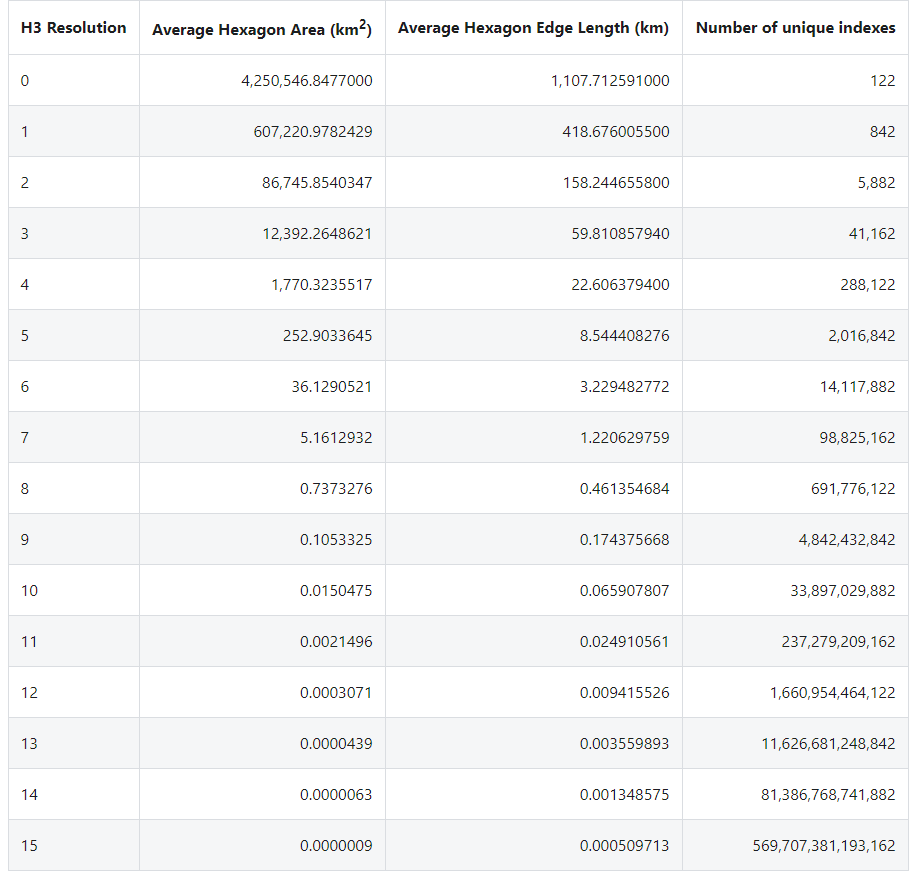

In [14]:
map_1 = KeplerGl()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [15]:
map_1.add_data(data=demand_joinna, name='demand')
map_1.save_to_html()
map_1

Map saved to keplergl_map.html!


KeplerGl(data={'demand': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, …